In [2]:
using SeisNoise, PyPlot, CUDA, Glob, HDF5, Combinatorics, Random, Statistics, ImageFiltering, FFTW, JLD2, Dates
using CSV,DataFrames,SineFit,DSP,Interpolations
import SeisNoise: NoiseData
import SeisIO: read_nodal, NodalData, InstrumentPosition, InstrumentResponse, 
       show_str, show_t, show_x, show_os, timestamp
import FFTW: rfft, irfft
import Base:show, size, summary
import DSP
include("correlation_codes/Types.jl")
include("correlation_codes/Nodal.jl")
include("correlation_codes/Misc.jl")

compute_rms (generic function with 3 methods)

In [4]:
# list all 1khz and resampled Greenland files
path_1khz = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/"
path_resampled = "/1-fnp/pnwstore1/p-wd05/greenland/resampled/"
files_1khz = glob("1kHz/*",path_1khz)
files_resampled = glob("*",path_resampled)
files = cat(files_1khz,files_resampled,dims=1)
N = read_nodal("segy", files[2])

# choose channels
chan_start = 333
chan_end = Int64(N.n-chan_start+1)
chans = [chan_start,chan_end]

# set filter band
freqmin,freqmax = 1,100
fs = freqmax*2+1

# set out path
out_path = "/fd1/solinger/rms/1-100Hz/"

"/fd1/solinger/rms/1-100Hz/"

In [ ]:
# carry out running rms computation
rms = compute_rms(files[2264:2268],freqmin,freqmax,fs,chans,out_path,30000,500)

In [ ]:
# filter to more effectively isolate surface melt noise, then make rms plot with that

In [5]:
# read rms results
rms_mat_1 = JLD2.load(out_path*"rms.jld2")["rms"]
t_das = JLD2.load(out_path*"t.jld2")["t"]
rms_mat_2 = JLD2.load(out_path*"resampled_rms.jld2")["rms"]

# combine
rms_mat_1[:,2263:end] = rms_mat_2
rms_mat = rms_mat_1

# sum across middle
rms_leg_1 = rms_mat[1:div(size(rms_mat,1),2),:]
rms_leg_2 = reverse(rms_mat[div(size(rms_mat,1),2)+1:end,:],dims=1)
rms_mat_stack = (rms_leg_1 + rms_leg_2) ./ 2

# filter out high frequencies
responsetype = DSP.Filters.Lowpass(0.0001; fs=1/30)
designmethod = DSP.Filters.Butterworth(4)
rms_filt = DSP.Filters.filt(DSP.Filters.digitalfilter(responsetype, designmethod), rms_leg_1')'

1012×8891 Matrix{Float64}:
 43.7115   83.8137   93.8461   239.403    …  9.67385  11.1741   10.92
 43.2394   73.5872   67.0609   227.656       9.34272  10.4572   10.1912
 44.1004   67.1866   67.7874   218.068       9.53166   9.99382   9.71422
 43.5767   65.6089   69.4628   219.137       9.15294   9.90283   9.3358
 41.5809   66.3571   69.4909   220.169       9.1393    9.56307   9.15481
 38.5499   63.3833   67.5514   214.666    …  8.78147   9.22539   8.86348
 32.1465   54.3472   63.7156   203.844       8.55429   8.87935   8.4626
 30.4583   49.4339   58.3269   186.402       8.59567   8.90412   8.47044
 28.3121   42.923    52.2084   172.544       8.65646   8.974     8.4865
 24.3254   35.9515   34.8971   128.554       8.61291   8.79665   8.4631
 26.4881   32.5018   32.5743   135.074    …  8.56439   8.74079   8.27889
 28.7439   31.3842   36.0628   139.881       8.85067   8.88749   8.57837
 30.5543   34.6897   42.359    169.613       8.71826   8.67784   8.58794
  ⋮                             

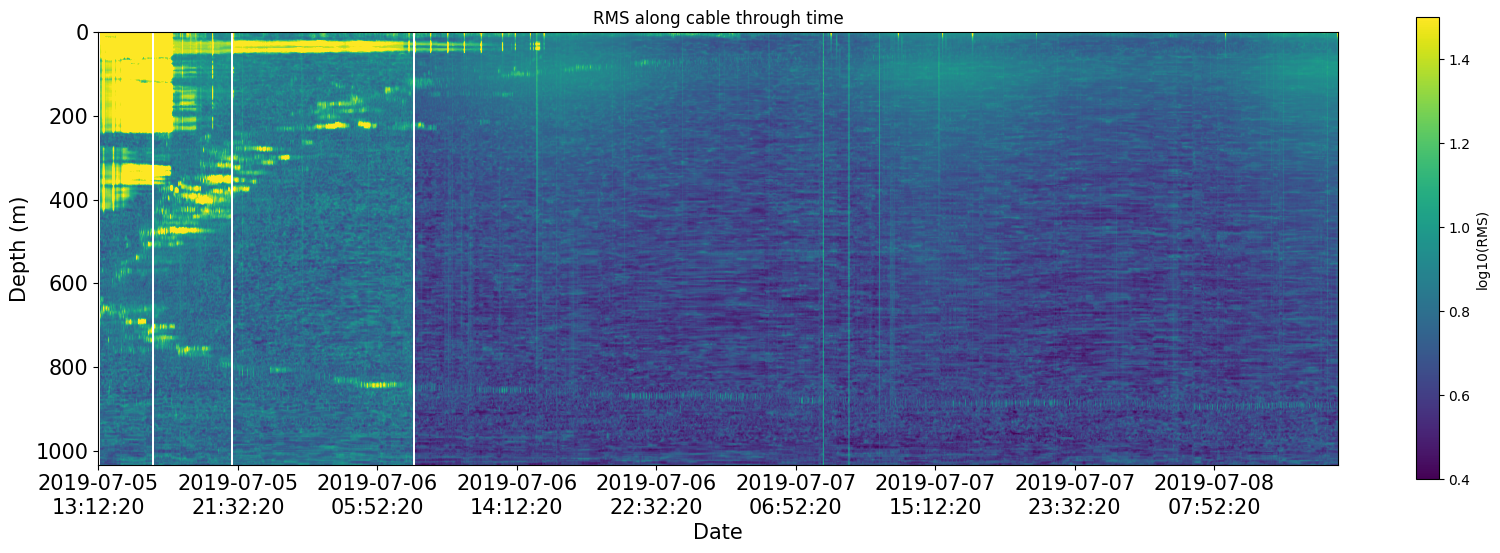

In [6]:
plt.figure(figsize=(20,6))
spacing = (N.misc[4]["shot_point"]-N.misc[3]["shot_point"])/1000
bottom = size(rms_leg_1,1)*spacing
plt.imshow(log.(10,rms_leg_1),vmin=0.4,vmax=1.5,aspect=3,extent=(1,size(rms_leg_1,2),bottom,0))
plt.colorbar(label="log10(RMS)")
xtick_loc = range(1,size(rms_leg_1,2),step = 1000)
xtick_dates = t_das[range(1,size(rms_leg_1,2),step = 1000)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_loc,xtick_labels,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Depth (m)",fontsize=15)
plt.title("RMS along cable through time")
plt.savefig("figures/rms_fig.png")

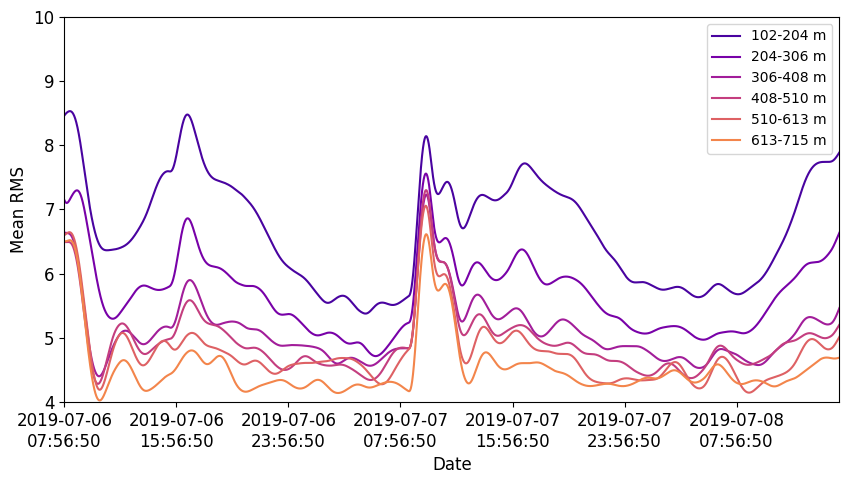

PyObject Text(28.000000000000007, 0.5, 'Mean RMS')

In [8]:
# make plots of near-surface diurnal rms (show decay through depth)
interval = 100
start = 2250
fig,ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.plasma
cmaplist = [cmap(i) for i in range(1,cmap.N)]
j = 1
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax.plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*30])
    j += 1
end
plt.legend()
xtick_dates = t_das[range(start,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,xtick_labels,fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(4,10)
ax.set_xlim(t_das[start],t_das[end])
ax.set_xlabel("Date",fontsize=12)
ax.set_ylabel("Mean RMS",fontsize=12)

In [ ]:
# choose channel and duration
chans = [1330,1340]
sec_per_file = 30
#duration = 864000
#num_files = duration/sec_per_file
num_files = size(files,1)
start_file = 2

# read file in the "good" part of the data
trace = Float64[]
for i = 1:num_files
    N = read_nodal("segy", files[Int64(start_file+i)])
    data = N.data[:,chans[1]:chans[2]]
    stack = sum(data,dims=2)./size(data,2)
    trace = cat(trace,stack,dims=1)
end

# save trace
JLD2.save("/1-fnp/pnwstore1/p-wd05/greenland/misc/chan_"*string(chans[1])*"-"*string(chans[2])*"_combined_trace.jld2", "trace", trace)

In [9]:
# read water pressure
p_BH19c = DataFrame(CSV.File("borehole_data/BH19c_pressure.csv"))
format = "yyyy-mm-dd HH:MM:SS"
t_BH19c =  [DateTime(p_BH19c[i,1],format) for i in range(1,size(p_BH19c,1))]

# read BH19e pressure and ice velocity
p_BH19e = DataFrame(CSV.File("borehole_data/BH19e_pressure.csv"))
t_BH19e =  [DateTime(p_BH19e[i,1],format) for i in range(1,size(p_BH19e,1))]
gnss = DataFrame(CSV.File("borehole_data/R30_GNSS.csv"))
t_gnss = [DateTime(gnss[i,1],format) for i in range(1,size(gnss,1))]

# extract part that corresponds to the DAS deployment
format = dateformat"y-m-d H:M:S"
before_end = [DateTime(p_BH19c[i,1],format) .< t_das[end] for i in range(1,size(p_BH19c,1))]
after_start = [DateTime(p_BH19c[i,1],format) .> t_das[1] for i in range(1,size(p_BH19c,1))]
in_window = [before_end.+after_start .== 2][1]
p_BH19c_during_DAS = p_BH19c[in_window,:]
t_BH19c_during_DAS =  [DateTime(p_BH19c_during_DAS[i,1],format) for i in range(1,size(p_BH19c_during_DAS,1))]

870-element Vector{DateTime}:
 2019-07-05T13:14:57
 2019-07-05T13:19:57
 2019-07-05T13:24:57
 2019-07-05T13:29:57
 2019-07-05T13:34:57
 2019-07-05T13:39:57
 2019-07-05T13:44:57
 2019-07-05T13:49:57
 2019-07-05T13:54:57
 2019-07-05T13:59:57
 2019-07-05T14:04:57
 2019-07-05T14:09:57
 2019-07-05T14:14:57
 ⋮
 2019-07-08T14:19:57
 2019-07-08T14:24:57
 2019-07-08T14:29:57
 2019-07-08T14:34:57
 2019-07-08T14:39:57
 2019-07-08T14:44:57
 2019-07-08T14:49:57
 2019-07-08T14:54:57
 2019-07-08T14:59:57
 2019-07-08T15:04:57
 2019-07-08T15:09:57
 2019-07-08T15:14:57

In [ ]:
# read combined trace
trace = JLD2.load("/1-fnp/pnwstore1/p-wd05/greenland/misc/chan_1330-1340_combined_trace.jld2")["trace"]

# set window size in seconds
win_size = 2000

# make spectrogram
fs = N.fs[1]
spec = DSP.Periodograms.spectrogram(trace[:,1], Int64(win_size*fs), round(Int64,0.95*win_size*N.fs[1]),fs=fs)

# get time axis
spec_time = [t_das[1]+Second(st) for st in spec.time]

In [ ]:
# plot spectrogram
fig,ax = plt.subplots(2,1,figsize=(10,7),gridspec_kw=Dict("height_ratios" => [1,2]))
ax[2].imshow(reverse(log.(10,spec.power),dims=1),extent=(spec.time[1],spec.time[end],spec.freq[2],spec.freq[end]),aspect="auto",vmin=-1,vmax=0.75)
xtick_loc = spec.time[range(1,size(spec.time,1),step = 1000)]
xtick_dates = spec_time[range(1,size(spec.time,1),step = 1000)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_loc,xtick_labels)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
ax[2].set_ylim(4e-3,10)
ax[2].set_yscale("log")

interval = 250
j = 1
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax[1].plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
ax[1].legend(loc=3)
ax3 = ax[1].twinx()
#ax3.plot(t_borehole,p_during_DAS[:,3],label="Pressure",c="blue",linestyle="--",linewidth=3)
ax3.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="BH19e",c="red",linestyle="--",linewidth=4)
mean_p = Statistics.mean(p_BH19c_during_DAS[:,3])
flipped_p = mean_p .+ (p_BH19c_during_DAS[:,3].-mean_p)*-1
mean_vel = Statistics.mean(gnss[80:end,6])
ax3.plot(t_gnss[80:end].-Day(16),(gnss[80:end,6].-mean_vel)*0.05.+mean_vel.+223,label="Velocity",c="orange")
ax3.set_ylim(770,780)
xtick_dates = t_das[range(1,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,[],fontsize=12)
plt.yticks(fontsize=12)
ax3.legend(loc=2)
ax[1].set_ylim(4,10)
ax[1].grid("major",axis="x")
ax3.set_xlim(t_das[1],t_das[end])
ax3.set_xlabel("Date",fontsize=12)
ax3.set_ylabel("Hydraulic head (m)",fontsize=12)
ax[1].set_ylabel("Mean RMS",fontsize=12)
plt.savefig("figures/pressure_rms_spec_vel.png",dpi=150)

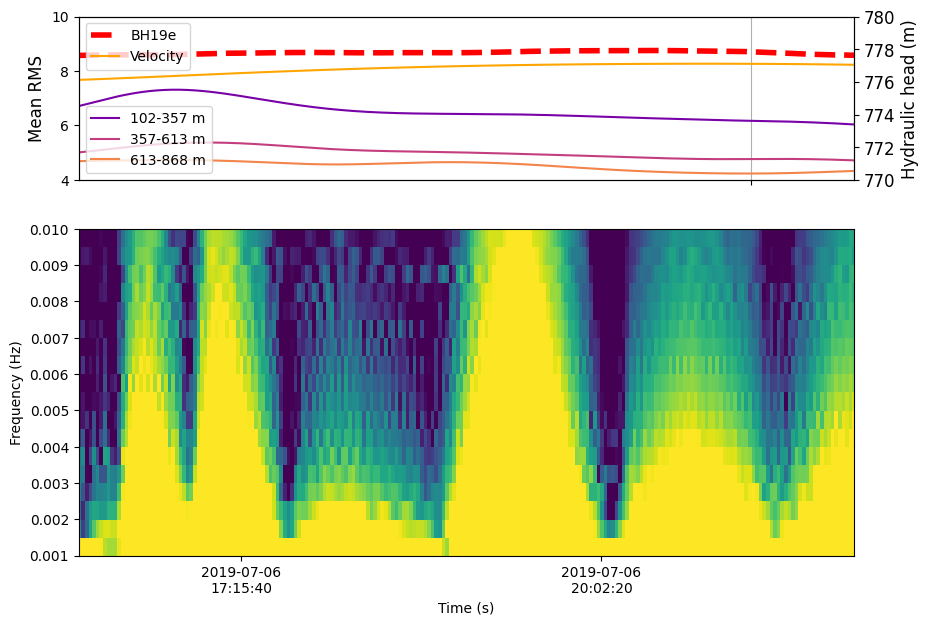

In [19]:
# plot a subset of the spectrogram
starttime = DateTime(2019,7,6,16)
endtime = DateTime(2019,7,6,22)
ind = intersect(findall(x->x > starttime, spec_time), findall(x->x < endtime, spec_time))

# set frequency band
freq = [0.001,0.01]

# plot spectrogram
fig,ax = plt.subplots(2,1,figsize=(10,7),gridspec_kw=Dict("height_ratios" => [1,2]))
ax[2].imshow(reverse(log.(10,spec.power),dims=1),extent=(spec.time[1],spec.time[end],spec.freq[2],spec.freq[end]),aspect="auto",vmin=-1,vmax=0.75)
xtick_loc = spec.time[range(1,size(spec.time,1),step = 100)]
xtick_dates = spec_time[range(1,size(spec.time,1),step = 100)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_loc,xtick_labels)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
ax[2].set_ylim(freq[1],freq[2])

interval = 250
j = 1
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax[1].plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
ax[1].legend(loc=3)
ax3 = ax[1].twinx()
#ax3.plot(t_borehole,p_during_DAS[:,3],label="Pressure",c="blue",linestyle="--",linewidth=3)
ax3.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="BH19e",c="red",linestyle="--",linewidth=4)
mean_p = Statistics.mean(p_BH19c_during_DAS[:,3])
flipped_p = mean_p .+ (p_BH19c_during_DAS[:,3].-mean_p)*-1
mean_vel = Statistics.mean(gnss[80:end,6])
ax3.plot(t_gnss[80:end].-Day(16),(gnss[80:end,6].-mean_vel)*0.05.+mean_vel.+223,label="Velocity",c="orange")
ax3.set_ylim(770,780)
xtick_dates = t_das[range(1,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,[],fontsize=12)
plt.yticks(fontsize=12)
ax3.legend(loc=2)
ax[1].set_ylim(4,10)
ax[1].grid("major",axis="x")
ax3.set_xlabel("Date",fontsize=12)
ax3.set_ylabel("Hydraulic head (m)",fontsize=12)
ax[1].set_ylabel("Mean RMS",fontsize=12)

# xlim
#ax[2].set_xlim(starttime,endtime)
ax3.set_xlim(starttime,endtime)
ax[2].set_xlim(spec.time[ind][1],spec.time[ind][end])
plt.savefig("figures/pressure_rms_spec_vel_"*string(freq[1])*"-"*string(freq[2])*"Hz_T16:00-22:00.png",dpi=150)

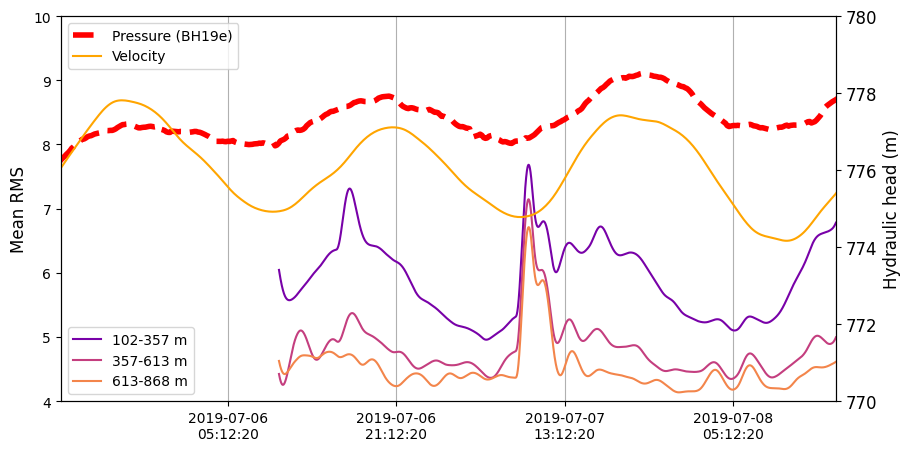

In [46]:
# plot a subset of the spectrogram
starttime = DateTime(2019,7,5,13,17,20)
endtime = DateTime(2019,7,8,15)
ind = intersect(findall(x->x > starttime, spec_time), findall(x->x < endtime, spec_time))

# set frequency band
freq = [0.001,0.01]

# plot spectrogram
fig,ax = plt.subplots(1,1,figsize=(10,5))

interval = 250
j = 1
start = 2500
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax.plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
ax.legend(loc=3)
ax3 = ax.twinx()
#ax3.plot(t_borehole,p_during_DAS[:,3],label="Pressure",c="blue",linestyle="--",linewidth=3)
ax3.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="Pressure (BH19e)",c="red",linestyle="--",linewidth=4)
mean_p = Statistics.mean(p_BH19c_during_DAS[:,3])
flipped_p = mean_p .+ (p_BH19c_during_DAS[:,3].-mean_p)*-1
mean_vel = Statistics.mean(gnss[80:end,6])
ax3.plot(t_gnss[80:end].-Day(16),(gnss[80:end,6].-mean_vel)*0.05.+mean_vel.+223,label="Velocity",c="orange")
ax3.set_ylim(770,780)
xtick_dates = t_das[range(1,size(rms_filt,2),step = 960*2)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,xtick_labels,fontsize=12)
plt.yticks(fontsize=12)
ax3.legend(loc=2)
ax.set_ylim(4,10)
ax.grid("major",axis="x")
ax3.set_xlabel("Date",fontsize=12)
ax3.set_ylabel("Hydraulic head (m)",fontsize=12)
ax.set_ylabel("Mean RMS",fontsize=12)

# xlim
#ax[2].set_xlim(starttime,endtime)
ax3.set_xlim(starttime,endtime)
plt.savefig("figures/pressure_rms_vel",dpi=150)

In [ ]:
# regress BH19c pressure, BH19e pressure, and ice velocity
p_BH19e = DataFrame(CSV.File("borehole_data/BH19e_pressure.csv"))
t_BH19e =  [DateTime(p_BH19e[i,1],format) for i in range(1,size(p_BH19e,1))]
gnss = DataFrame(CSV.File("borehole_data/R30_GNSS.csv"))
t_gnss = [DateTime(gnss[i,1],format) for i in range(1,size(gnss,1))]

# choose start and end times
reg_start = t_BH19e[7500]
reg_end = t_gnss[end]
reg_BH19e = p_BH19e[t_BH19e .> reg_start,:] 
reg_t_BH19e = t_BH19e[t_BH19e .> reg_start] 
reg_BH19c = p_BH19c[t_BH19c .> reg_start,:] 
reg_t_BH19c = t_BH19c[t_BH19c .> reg_start] 
reg_gnss = gnss[t_gnss .> reg_start,:]
reg_t_gnss = t_gnss[t_gnss .> reg_start]

# split borehole pressures where sample rate changes


# interpolate each part of both pressure curve

# put borehole pressures on same time axis as gnss

In [ ]:
# interpolate gnss get seconds since start time
itp_BH19c = interpolate(reg_BH19c[:,3], BSpline(Constant()))
itp_BH19e = interpolate(reg_BH19e[:,3], BSpline(Constant()))
itp_points_BH19c = range(1,size(reg_t_BH19c,1),step=size(reg_t_BH19c,1)/size(reg_t_gnss,1))
itp_points_BH19e = range(1,size(reg_t_BH19e,1),step=size(reg_t_BH19e,1)/size(reg_t_gnss,1))

In [ ]:
diffs = diff(diff(reg_t_BH19e))
diffs = [diffs[i].value for i in range(1,(size(diffs,1)))]
kink = findall(x -> x == sum(diffs),diffs)

In [ ]:
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(t_BH19e[7500:end],p_BH19e[7500:end,3],label="BH19e pressure",c="red",linestyle="--",linewidth=2)
ax1.plot(t_BH19c[500:end],p_BH19c[500:end,3],label="BH19c pressure",c="blue",linestyle="--",linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Hydraulic head (m)")
ax2 = ax1.twinx()
ax2.set_ylabel("Velocity (m/year)")
ax2.plot(t_gnss,gnss[:,6],c="orange",label="Velocity")
ax1.set_ylim(770,780)
ax2.set_ylim(350,630)
ax1.set_xlim(t_BH19c[5000],t_BH19c[end])
ax1.vlines((t_das[1],t_das[end]),770,790,linestyle="-",colors="k")
ax1.legend(loc=2)
ax2.legend(loc=1)
date_plot_fmt=matplotlib.dates.DateFormatter("%m-%d")
ax1.xaxis.set_major_formatter(date_plot_fmt)
plt.savefig("figures/pressure_and_velocity_zoom.png",dpi=150)

In [ ]:
# plot water pressure and surface noise rms
interval = 250
start = 2500
fig,ax = plt.subplots(figsize=(10,5))
cmap = plt.cm.plasma  # define the colormap
cmaplist = [cmap(i) for i in range(1,cmap.N)]
j = 1
for i in range(100,600,step=interval)
    mean_trace = sum(rms_filt[i:i+interval,start:end],dims=1)'./interval
    d1 = string(Int64(round(i*spacing)))
    d2 = string(Int64(round((i+interval)*spacing)))
    lab = string(d1*"-"*d2*" m")
    ax.plot(t_das[start:end],mean_trace,label=lab,c=cmaplist[j*60])
    j+=1
end
plt.legend()
ax1 = ax.twinx()
ax1.plot(t_BH19e.-Day(25).-Minute(40),p_BH19e[:,3],label="BH19e",c="red",linestyle="--",linewidth=4)
ax1.plot(t_BH19c_during_DAS,p_BH19c_during_DAS[:,3],c="blue",label="BH19c",linestyle="--",linewidth=4)
ax.legend(loc=3)
ax1.legend(loc=1)
ax1.set_ylim(760,780)
xtick_dates = t_das[range(start,size(rms_filt,2),step = 960)]
xtick_labels = [Dates.format(xtick_dates[i], "yyyy-mm-dd\nHH:MM:SS") for i in range(1,size(xtick_dates,1))]
plt.xticks(xtick_dates,xtick_labels,fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(4,12)
ax.set_xlim(t_das[start],t_das[end])
ax.set_xlabel("Date",fontsize=12)
ax1.set_ylabel("Hydraulic head (m)",fontsize=12)
ax.set_ylabel("Mean RMS",fontsize=12)
plt.show()
plt.savefig("figures/surface_noise_pressure_both",dpi=120)

In [ ]:
# do rms <0.25 Hz

# do rms on (0.01-0.1) and (0.0001-0.01). Requires sticking files together

In [3]:
# read data
trace = JLD2.load("/fd1/solinger/chan_1330-1340_combined_trace.jld2")["trace"]

# get time values for our trace 
N = read_nodal("segy", files[2])
t_trace = [t_das[1]+Millisecond(dt) for dt in range(1,size(trace,1))]

LoadError: UndefVarError: files not defined

In [4]:
# isolate the time period we want
win_start = DateTime(2019,7,6,16,32,40)
win_end = win_start + Second(10)
window_ind1 = [t .> win_start]
window_ind2 = [t .< win_end]
window_ind = window_ind1 + window_ind2
window_ind = [window_ind[1] .== 2]

# filter the trace
freq = [10,25]
responsetype = DSP.Filters.Bandpass(freq[1],freq[2]; fs=1000)
designmethod = DSP.Filters.Butterworth(4)
trace_filt = DSP.Filters.filt(DSP.Filters.digitalfilter(responsetype, designmethod), trace[window_ind[1]])

# plot the filtered trace
plt.plot(t[window_ind[1]],trace_filt)

# plot 0.001, 1-10, 10-100z at July 7 0:00



LoadError: UndefVarError: t not defined